# Data viz ideas

## There's two main parts to this:
1) Dashboard building
2) Actual plots and such 
    - Most worn items per category 
    - Top colors worn
    - Parse data by season (winter/spring/summer/fall)

In [1]:
from dash import Dash, html, dcc, Input, Output
import altair as alt
import dash_bootstrap_components as dbc
import pandas as pd
import numpy as np
import matplotlib as plt
from matplotlib.pyplot import figure

import datetime
import calmap
import sheworewhat as sww

alt.data_transformers.disable_max_rows()
# alt.renderers.enable('notebook')

DataTransformerRegistry.enable('default')

In [2]:
closet = sww.closet_df()

closet

,ID,Item,Category,Sub-Category,Color,Pattern,Brand,Bought,Cost,2023,Price,PrimaryC,Name
0,0,Turtleneck,Top,Sweater,Black,Plain,Zara,"Secondhand, Thrifted",cheap,No,NaN,Black,0 Zara Turtleneck - Black
1,1,Tank,Top,Tanktop,"Black, Red, Gold",Feather,Plisse,"Secondhand, Thrifted",cheap,No,NaN,Black,1 Plisse Tank - Black
2,2,Tank,Top,Tanktop,"Black, Tan",Leopard,Plisse,"Secondhand, Thrifted",cheap,No,15.0,Black,2 Plisse Tank - Black
3,3,Jeans,Bottom,Pants,Blue,Plain,Aerie,New,cheap,No,NaN,Blue,3 Aerie Jeans - Blue
4,4,Shirt,Top,Shirt,"Black, White",Cheetah,Free People,"Secondhand, Depop",cheap,No,NaN,Black,4 Free People Shirt - Black
...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,83,Square Hoops,Accessory,Jewelry,Gold,Plain,Tj Maxx,New,cheap,No,NaN,Gold,83 Tj Maxx Square Hoops - Gold
84,84,Puffer,Outerwear,Coat,Green,Plain,Hollister,New,pricy,No,NaN,Green,84 Hollister Puffer - Green
85,85,Tote Bag,Accessory,Bag,Green,Logo,Ubc,New,cheap,No,NaN,Green,85 Ubc Tote Bag - Green
86,86,Purse,Accessory,Bag,White,Vintage,No Brand,"Secondhand, Depop",cheap,No,NaN,White,86 No Brand Purse - White


In [3]:
acc_df, bottom_df, fb_df, out_df, shoes_df, top_df = sww.closet_cat(closet)

acc_df.tail(5)

,ID,Item,Category,Sub-Category,Color,Pattern,Brand,Bought,Cost,2023,Price,PrimaryC,Name
82,82,Christmas Tree Hoops,Accessory,Jewelry,Gold,Plain,No Brand,"Secondhand, Thrifted",cheap,No,NaN,Gold,82 No Brand Christmas Tree Hoops - Gold
83,83,Square Hoops,Accessory,Jewelry,Gold,Plain,Tj Maxx,New,cheap,No,NaN,Gold,83 Tj Maxx Square Hoops - Gold
85,85,Tote Bag,Accessory,Bag,Green,Logo,Ubc,New,cheap,No,NaN,Green,85 Ubc Tote Bag - Green
86,86,Purse,Accessory,Bag,White,Vintage,No Brand,"Secondhand, Depop",cheap,No,NaN,White,86 No Brand Purse - White
87,87,Bow,Accessory,Hat,Black,Plain,Target,New,cheap,No,10.0,Black,87 Target Bow - Black


## Closet EDA
- What percentage of my closet is new vs. secondhand?

In [4]:
closet_count = closet.groupby(by="Bought").count()
closet_count

,ID,Item,Category,Sub-Category,Color,Pattern,Brand,Cost,2023,Price,PrimaryC,Name
Bought,,,,,,,,,,,,
New,44,44,44,44,44,44,44,44,44,1,44,44
"Secondhand, Depop",2,2,2,2,2,2,2,2,2,0,2,2
"Secondhand, Gifted",5,5,5,5,5,5,5,5,5,0,5,5
"Secondhand, Thrifted",37,37,37,37,37,37,37,37,37,3,37,37


In [5]:
closet_n = closet.groupby(["Bought"])[["Bought"]].agg('count').rename(columns={"Bought" : "N"}).reset_index()
closet_n["Percent"] = (closet_n['N'] / len(closet))
closet_n

,Bought,N,Percent
0,New,44,0.500000
1,"Secondhand, Depop",2,0.022727
2,"Secondhand, Gifted",5,0.056818
3,"Secondhand, Thrifted",37,0.420455


Should I do just secondhand? then breakdown the secondhand

In [6]:
closet_n = closet.groupby(["Bought"])[["Bought"]].agg('count').rename(columns={"Bought" : "N"}).reset_index()
closet_n["Percent"] = (closet_n['N'] / len(closet))

closet_n["Status"] = closet_n["Bought"].str.split(",").str[1]
closet_n = closet_n.replace(np.nan, "New")

closet_comp = alt.Chart(closet_n, title="Closet Composition"
                       ).mark_bar(color="Maroon"
                         ).encode(alt.X("Bought", axis=alt.Axis(labelAngle=-45), sort='-y'),
                                  alt.Y("Percent", axis=alt.Axis(format='%'),),
                                  alt.Tooltip("Percent", format=",.2f"),
                                  color=alt.condition(
                                    alt.datum.year == "New",
                                    alt.value('orange'),
                                    alt.value('maroon')   
                                    )
                                 )
                
closet_comp

alt.Chart(...)

In [7]:
closet_n = closet.groupby(["Bought"])[["Bought"]].agg('count').rename(columns={"Bought" : "N"}).reset_index()
closet_n["Percent"] = (closet_n['N'] / len(closet))

closet_n["Purchased"] = closet_n["Bought"].str.split(",").str[0]
closet_n["Status"] = closet_n["Bought"].str.split(",").str[1]
closet_n = closet_n.replace(np.nan, "New")

closet_n

,Bought,N,Percent,Purchased,Status
0,New,44,0.500000,New,New
1,"Secondhand, Depop",2,0.022727,Secondhand,Depop
2,"Secondhand, Gifted",5,0.056818,Secondhand,Gifted
3,"Secondhand, Thrifted",37,0.420455,Secondhand,Thrifted


In [8]:
closet_n.groupby(["Purchased"]).count()

,Bought,N,Percent,Status
Purchased,,,,
New,1,1,1,1
Secondhand,3,3,3,3


In [9]:
# new vs secondhand only plot
closet_comp = alt.Chart(closet_n, title="Closet Composition"
                       ).mark_bar(color="Maroon"
                         ).encode(alt.X("Bought", axis=alt.Axis(labelAngle=-45), sort='-y'),
                                  alt.Y("Percent", axis=alt.Axis(format='%'),),
                                  alt.Tooltip("Percent", format=",.2f"),
                                  color=alt.condition(
                                    alt.datum.year == "New",
                                    alt.value('orange'),
                                    alt.value('maroon')   
                                    )
                                 )
                
closet_comp

alt.Chart(...)

## clean and merge data
- need function to clean, merge, do counts and stuff for collected data

In [10]:
path = "../data/2023TestData.csv"

df = pd.read_csv(path)
df

,Timestamp,Date,Accessory,Shoes,Outerwear,Full Body,Bottom,Top,Top2,Accessory2,Accessory3,Accessory4,Note
0,12/21/2022 20:27:23,12/19/2022,10 Athleta Beanie - Tan,75 Adidas Tennis Shoe - Black,84 Hollister Puffer - Green,NaN,24 Aerie Leggings - Green,16 Aerie Sports Bra - Green,50 Glossier Crewneck Sweater - Gray,85 Ubc Tote Bag - Green,NaN,NaN,NaN
1,12/21/2022 20:28:00,12/20/2022,10 Athleta Beanie - Tan,75 Adidas Tennis Shoe - Black,84 Hollister Puffer - Green,NaN,24 Aerie Leggings - Green,16 Aerie Sports Bra - Green,50 Glossier Crewneck Sweater - Gray,85 Ubc Tote Bag - Green,NaN,NaN,NaN
2,12/21/2022 20:28:30,12/21/2022,10 Athleta Beanie - Tan,75 Adidas Tennis Shoe - Black,84 Hollister Puffer - Green,NaN,26 Aerie Leggings - Black,17 Aerie Sports Bra - Black,50 Glossier Crewneck Sweater - Gray,85 Ubc Tote Bag - Green,NaN,NaN,NaN
3,12/21/2022 20:30:40,12/22/2022,85 Ubc Tote Bag - Green,9 Blondo Boots - Black,84 Hollister Puffer - Green,NaN,3 Aerie Jeans - Blue,2 Plisse Tank - Black,NaN,81 No Brand Gold Hoops - Gold,NaN,NaN,NaN
4,12/21/2022 20:33:50,12/23/2022,82 No Brand Christmas Tree Hoops - Gold,9 Blondo Boots - Black,84 Hollister Puffer - Green,57 American Eagle Maxi Dress - Green,NaN,6 Express Body Suit - White,46 No Brand Vest - White,NaN,NaN,NaN,NaN
5,12/22/2022 17:51:54,12/22/2022,81 No Brand Gold Hoops - Gold,9 Blondo Boots - Black,84 Hollister Puffer - Green,NaN,3 Aerie Jeans - Blue,5 Express Body Suit - Black,38 Hollister Cardigan - Black,85 Ubc Tote Bag - Green,87 Target Bow - Black,NaN,NaN
6,12/24/2022 11:25:47,12/23/2022,85 Ubc Tote Bag - Green,9 Blondo Boots - Black,84 Hollister Puffer - Green,NaN,4 Aerie Jeans - Blue,5 Express Body Suit - Black,38 Hollister Cardigan - Black,87 Target Bow - Black,83 Tj Maxx Square Hoops - Gold,NaN,NaN
7,12/24/2022 17:15:54,12/24/2022,82 No Brand Christmas Tree Hoops - Gold,9 Blondo Boots - Black,84 Hollister Puffer - Green,NaN,3 Aerie Jeans - Blue,31 Marisa Christina Christmas Sweater - Navy,NaN,72 Karl Lagerfield Crossbody - Black,NaN,NaN,NaN
8,12/25/2022 18:21:35,12/25/2022,82 No Brand Christmas Tree Hoops - Gold,77 Marshall'S Knee-High Boots - Black,NaN,NaN,7 Girlfriend Collective Skort - Black,37 Sml Christmas Vest - Black,33 No Brand Christmas Sweater - Black,85 Ubc Tote Bag - Green,87 Target Bow - Black,NaN,NaN


We don't need the timestamp, its redundant and easier to just use date

In [11]:
df.iloc[:, 1:]

,Date,Accessory,Shoes,Outerwear,Full Body,Bottom,Top,Top2,Accessory2,Accessory3,Accessory4,Note
0,12/19/2022,10 Athleta Beanie - Tan,75 Adidas Tennis Shoe - Black,84 Hollister Puffer - Green,NaN,24 Aerie Leggings - Green,16 Aerie Sports Bra - Green,50 Glossier Crewneck Sweater - Gray,85 Ubc Tote Bag - Green,NaN,NaN,NaN
1,12/20/2022,10 Athleta Beanie - Tan,75 Adidas Tennis Shoe - Black,84 Hollister Puffer - Green,NaN,24 Aerie Leggings - Green,16 Aerie Sports Bra - Green,50 Glossier Crewneck Sweater - Gray,85 Ubc Tote Bag - Green,NaN,NaN,NaN
2,12/21/2022,10 Athleta Beanie - Tan,75 Adidas Tennis Shoe - Black,84 Hollister Puffer - Green,NaN,26 Aerie Leggings - Black,17 Aerie Sports Bra - Black,50 Glossier Crewneck Sweater - Gray,85 Ubc Tote Bag - Green,NaN,NaN,NaN
3,12/22/2022,85 Ubc Tote Bag - Green,9 Blondo Boots - Black,84 Hollister Puffer - Green,NaN,3 Aerie Jeans - Blue,2 Plisse Tank - Black,NaN,81 No Brand Gold Hoops - Gold,NaN,NaN,NaN
4,12/23/2022,82 No Brand Christmas Tree Hoops - Gold,9 Blondo Boots - Black,84 Hollister Puffer - Green,57 American Eagle Maxi Dress - Green,NaN,6 Express Body Suit - White,46 No Brand Vest - White,NaN,NaN,NaN,NaN
5,12/22/2022,81 No Brand Gold Hoops - Gold,9 Blondo Boots - Black,84 Hollister Puffer - Green,NaN,3 Aerie Jeans - Blue,5 Express Body Suit - Black,38 Hollister Cardigan - Black,85 Ubc Tote Bag - Green,87 Target Bow - Black,NaN,NaN
6,12/23/2022,85 Ubc Tote Bag - Green,9 Blondo Boots - Black,84 Hollister Puffer - Green,NaN,4 Aerie Jeans - Blue,5 Express Body Suit - Black,38 Hollister Cardigan - Black,87 Target Bow - Black,83 Tj Maxx Square Hoops - Gold,NaN,NaN
7,12/24/2022,82 No Brand Christmas Tree Hoops - Gold,9 Blondo Boots - Black,84 Hollister Puffer - Green,NaN,3 Aerie Jeans - Blue,31 Marisa Christina Christmas Sweater - Navy,NaN,72 Karl Lagerfield Crossbody - Black,NaN,NaN,NaN
8,12/25/2022,82 No Brand Christmas Tree Hoops - Gold,77 Marshall'S Knee-High Boots - Black,NaN,NaN,7 Girlfriend Collective Skort - Black,37 Sml Christmas Vest - Black,33 No Brand Christmas Sweater - Black,85 Ubc Tote Bag - Green,87 Target Bow - Black,NaN,NaN


In [12]:
df.drop("Timestamp", axis=1)

,Date,Accessory,Shoes,Outerwear,Full Body,Bottom,Top,Top2,Accessory2,Accessory3,Accessory4,Note
0,12/19/2022,10 Athleta Beanie - Tan,75 Adidas Tennis Shoe - Black,84 Hollister Puffer - Green,NaN,24 Aerie Leggings - Green,16 Aerie Sports Bra - Green,50 Glossier Crewneck Sweater - Gray,85 Ubc Tote Bag - Green,NaN,NaN,NaN
1,12/20/2022,10 Athleta Beanie - Tan,75 Adidas Tennis Shoe - Black,84 Hollister Puffer - Green,NaN,24 Aerie Leggings - Green,16 Aerie Sports Bra - Green,50 Glossier Crewneck Sweater - Gray,85 Ubc Tote Bag - Green,NaN,NaN,NaN
2,12/21/2022,10 Athleta Beanie - Tan,75 Adidas Tennis Shoe - Black,84 Hollister Puffer - Green,NaN,26 Aerie Leggings - Black,17 Aerie Sports Bra - Black,50 Glossier Crewneck Sweater - Gray,85 Ubc Tote Bag - Green,NaN,NaN,NaN
3,12/22/2022,85 Ubc Tote Bag - Green,9 Blondo Boots - Black,84 Hollister Puffer - Green,NaN,3 Aerie Jeans - Blue,2 Plisse Tank - Black,NaN,81 No Brand Gold Hoops - Gold,NaN,NaN,NaN
4,12/23/2022,82 No Brand Christmas Tree Hoops - Gold,9 Blondo Boots - Black,84 Hollister Puffer - Green,57 American Eagle Maxi Dress - Green,NaN,6 Express Body Suit - White,46 No Brand Vest - White,NaN,NaN,NaN,NaN
5,12/22/2022,81 No Brand Gold Hoops - Gold,9 Blondo Boots - Black,84 Hollister Puffer - Green,NaN,3 Aerie Jeans - Blue,5 Express Body Suit - Black,38 Hollister Cardigan - Black,85 Ubc Tote Bag - Green,87 Target Bow - Black,NaN,NaN
6,12/23/2022,85 Ubc Tote Bag - Green,9 Blondo Boots - Black,84 Hollister Puffer - Green,NaN,4 Aerie Jeans - Blue,5 Express Body Suit - Black,38 Hollister Cardigan - Black,87 Target Bow - Black,83 Tj Maxx Square Hoops - Gold,NaN,NaN
7,12/24/2022,82 No Brand Christmas Tree Hoops - Gold,9 Blondo Boots - Black,84 Hollister Puffer - Green,NaN,3 Aerie Jeans - Blue,31 Marisa Christina Christmas Sweater - Navy,NaN,72 Karl Lagerfield Crossbody - Black,NaN,NaN,NaN
8,12/25/2022,82 No Brand Christmas Tree Hoops - Gold,77 Marshall'S Knee-High Boots - Black,NaN,NaN,7 Girlfriend Collective Skort - Black,37 Sml Christmas Vest - Black,33 No Brand Christmas Sweater - Black,85 Ubc Tote Bag - Green,87 Target Bow - Black,NaN,NaN


two things: would be useful to have counts and also the dates in a list per item

Need to be able to handle multiple items in a single category (layering, etc)
- doesnt make sense to edit google sheet because layering can happen with all categories

In [13]:
path = "../data/2023TestData.csv"

df = pd.read_csv(path).drop("Timestamp", axis=1).melt("Date").dropna()

df

,Date,variable,value
0,12/19/2022,Accessory,10 Athleta Beanie - Tan
1,12/20/2022,Accessory,10 Athleta Beanie - Tan
2,12/21/2022,Accessory,10 Athleta Beanie - Tan
3,12/22/2022,Accessory,85 Ubc Tote Bag - Green
4,12/23/2022,Accessory,82 No Brand Christmas Tree Hoops - Gold
...,...,...,...
70,12/24/2022,Accessory2,72 Karl Lagerfield Crossbody - Black
71,12/25/2022,Accessory2,85 Ubc Tote Bag - Green
77,12/22/2022,Accessory3,87 Target Bow - Black
78,12/23/2022,Accessory3,83 Tj Maxx Square Hoops - Gold


In [14]:
df.groupby("value").count()

,Date,variable
value,,
10 Athleta Beanie - Tan,3,3
16 Aerie Sports Bra - Green,2,2
17 Aerie Sports Bra - Black,1,1
2 Plisse Tank - Black,1,1
24 Aerie Leggings - Green,2,2
26 Aerie Leggings - Black,1,1
3 Aerie Jeans - Blue,3,3
31 Marisa Christina Christmas Sweater - Navy,1,1
33 No Brand Christmas Sweater - Black,1,1


In [15]:
df["test0"] = df["value"].str.split(",").str[0]
df["test1"] = df["value"].str.split(",").str[1]
df.head(3)

,Date,variable,value,test0,test1
0,12/19/2022,Accessory,10 Athleta Beanie - Tan,10 Athleta Beanie - Tan,NaN
1,12/20/2022,Accessory,10 Athleta Beanie - Tan,10 Athleta Beanie - Tan,NaN
2,12/21/2022,Accessory,10 Athleta Beanie - Tan,10 Athleta Beanie - Tan,NaN


ugh maybe this can be reformatted somehow for easier parsing; also i dont love how the format is now

OR 
maybe if column contains more than 1 number, split it i

IDEA:
- GOOGLE SHEET FORM: ID ITEM - COLOR
- then multiple selections can be parse via "," in the sheet

In [16]:
# def closet
path = "../data/2023TestData.csv"

df = pd.read_csv(path).drop("Timestamp", axis=1).melt("Date").dropna()

# extract ID number from value
df["ID"] = df.value.str.extract('(\d+)').astype(int)

closet_counts = df.groupby(["value", "ID"]).count().reset_index().rename(columns={"Date":"count"}).drop(["variable"],axis=1)

closet_counts

# left join closet + df
x = pd.merge(closet, closet_counts, how="left", on="ID")
x

,ID,Item,Category,Sub-Category,Color,Pattern,Brand,Bought,Cost,2023,Price,PrimaryC,Name,value,count
0,0,Turtleneck,Top,Sweater,Black,Plain,Zara,"Secondhand, Thrifted",cheap,No,NaN,Black,0 Zara Turtleneck - Black,NaN,NaN
1,1,Tank,Top,Tanktop,"Black, Red, Gold",Feather,Plisse,"Secondhand, Thrifted",cheap,No,NaN,Black,1 Plisse Tank - Black,NaN,NaN
2,2,Tank,Top,Tanktop,"Black, Tan",Leopard,Plisse,"Secondhand, Thrifted",cheap,No,15.0,Black,2 Plisse Tank - Black,2 Plisse Tank - Black,1.0
3,3,Jeans,Bottom,Pants,Blue,Plain,Aerie,New,cheap,No,NaN,Blue,3 Aerie Jeans - Blue,3 Aerie Jeans - Blue,3.0
4,4,Shirt,Top,Shirt,"Black, White",Cheetah,Free People,"Secondhand, Depop",cheap,No,NaN,Black,4 Free People Shirt - Black,4 Aerie Jeans - Blue,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,83,Square Hoops,Accessory,Jewelry,Gold,Plain,Tj Maxx,New,cheap,No,NaN,Gold,83 Tj Maxx Square Hoops - Gold,83 Tj Maxx Square Hoops - Gold,1.0
84,84,Puffer,Outerwear,Coat,Green,Plain,Hollister,New,pricy,No,NaN,Green,84 Hollister Puffer - Green,84 Hollister Puffer - Green,8.0
85,85,Tote Bag,Accessory,Bag,Green,Logo,Ubc,New,cheap,No,NaN,Green,85 Ubc Tote Bag - Green,85 Ubc Tote Bag - Green,7.0
86,86,Purse,Accessory,Bag,White,Vintage,No Brand,"Secondhand, Depop",cheap,No,NaN,White,86 No Brand Purse - White,NaN,NaN


In [17]:
x = pd.merge(closet, df, on="ID")


In [18]:
closet_counts = df.groupby(["value"]).count().reset_index().rename(columns={"Date":"count"}).drop(["ID", "variable"],axis=1)
closet_counts

,value,count
0,10 Athleta Beanie - Tan,3
1,16 Aerie Sports Bra - Green,2
2,17 Aerie Sports Bra - Black,1
3,2 Plisse Tank - Black,1
4,24 Aerie Leggings - Green,2
5,26 Aerie Leggings - Black,1
6,3 Aerie Jeans - Blue,3
7,31 Marisa Christina Christmas Sweater - Navy,1
8,33 No Brand Christmas Sweater - Black,1
9,37 Sml Christmas Vest - Black,1


In [19]:
closet_comp = alt.Chart(closet_counts, title="2023 Most Worn Pieces"
                       ).mark_bar(color="Maroon"
                         ).encode(alt.X("value", axis=alt.Axis(labelAngle=-45), sort='-y'),
                                  alt.Y("count",),
                                  alt.Tooltip("value", format=",.2f"),
                                  color=alt.condition(
                                    alt.datum.year == "New",
                                    alt.value('orange'),
                                    alt.value('maroon')   
                                    )
                                 )
                
closet_comp

alt.Chart(...)

In [20]:
df.columns

Index(['Date', 'variable', 'value', 'ID'], dtype='object')

# Thotiana this is the easier way to plot count!!!

In [21]:
closet_comp = alt.Chart(df, title="2023 Most Worn Pieces"
                       ).mark_bar(color="Maroon"
                         ).encode(alt.X("Item", axis=alt.Axis(labelAngle=-45), sort="-y"),
                                  alt.Y("count()")
                                 )
                
closet_comp

ValueError: Item encoding field is specified without a type; the type cannot be inferred because it does not match any column in the data.

alt.Chart(...)

## its a mess up there but this is the function
1. takes in google form data
2. counts how many of each item logged
3. left joins with closet data

In [22]:
def complete_df(closet, path="../data/2023TestData.csv"):
    """
    Function to merge raw closet data and collected 2023 data.
    
    Parameters
    ----------
        closet : pandas.DataFrame
            Dataframe containing complete closet log.
        path : string
            String containing path of CSV of collected data.
    
    Returns
    -------
        complete_df : pandas.DataFrame
            Dataframe containing "ID", "Name", "count", "Item", 
            "Category", "Sub-Category", "Color", "Pattern", "Brand", "Cost", "2023"
    """


    form = pd.read_csv(path).drop("Timestamp", axis=1).melt("Date").dropna()

    # extract ID number from value
    form["ID"] = form.value.str.extract('(\d+)').astype(int)

    form_counts = form.groupby(["value", "ID"]).count().reset_index().rename(columns={"Date":"count"}).drop(["variable"],axis=1)
    
    # left join closet + df
    complete_df = pd.merge(closet, form_counts, how="left", on="ID")
    complete_df["Name"] = complete_df["Brand"] + " " + complete_df["Item"]
    complete_df = complete_df[["ID", "Name", "count", "Item", "Category", "Sub-Category", "Color", "Pattern", "Brand", "Cost", "2023"]]
    complete_df = complete_df.fillna(0).rename(columns={"count" : "Count"})
    complete_df["Count"] = complete_df["Count"].astype(int)
    
    return complete_df


In [23]:
closet = sww.closet_df()
worn_df = complete_df(closet)
worn_df

,ID,Name,Count,Item,Category,Sub-Category,Color,Pattern,Brand,Cost,2023
0,0,Zara Turtleneck,0,Turtleneck,Top,Sweater,Black,Plain,Zara,cheap,No
1,1,Plisse Tank,0,Tank,Top,Tanktop,"Black, Red, Gold",Feather,Plisse,cheap,No
2,2,Plisse Tank,1,Tank,Top,Tanktop,"Black, Tan",Leopard,Plisse,cheap,No
3,3,Aerie Jeans,3,Jeans,Bottom,Pants,Blue,Plain,Aerie,cheap,No
4,4,Free People Shirt,1,Shirt,Top,Shirt,"Black, White",Cheetah,Free People,cheap,No
...,...,...,...,...,...,...,...,...,...,...,...
83,83,Tj Maxx Square Hoops,1,Square Hoops,Accessory,Jewelry,Gold,Plain,Tj Maxx,cheap,No
84,84,Hollister Puffer,8,Puffer,Outerwear,Coat,Green,Plain,Hollister,pricy,No
85,85,Ubc Tote Bag,7,Tote Bag,Accessory,Bag,Green,Logo,Ubc,cheap,No
86,86,No Brand Purse,0,Purse,Accessory,Bag,White,Vintage,No Brand,cheap,No


In [24]:
worn_df["Count"].astype(int)

0     0
1     0
2     1
3     3
4     1
     ..
83    1
84    8
85    7
86    0
87    3
Name: Count, Length: 88, dtype: int64

## Some data viz

### 2023 Most Worn Pieces

In [25]:
most_worn = worn_df.nlargest(15, columns="Count")
closet_comp = alt.Chart(most_worn, title="2023 Most Worn Pieces"
                       ).mark_bar(color="Maroon"
                         ).encode(alt.X("Name", axis=alt.Axis(labelAngle=-45), sort="-y"),
                                  alt.Y("Count", 
                                        title="# of Times Worn",
                                        axis=alt.Axis(tickMinStep=1)),
                                  alt.Tooltip("Count")
                                 )
                
closet_comp

alt.Chart(...)

### Make similar plots but facet per category!

The problem with the below code is the x-axis is the same and we do not want that. We want the x axis to contain unique items for that category!
- Solution: generate 6 separate plots and concat

In [26]:
category_worn = worn_df.nlargest(15, columns="Count")
closet_comp = alt.Chart(category_worn, title="2023 Most Worn Pieces"
                       ).mark_bar(color="Maroon"
                       ).encode(alt.X("Name", axis=alt.Axis(labelAngle=-45), sort="-y"),
                                alt.Y("Count", 
                                title="# of Times Worn",
                                axis=alt.Axis(tickMinStep=1)),
                                alt.Tooltip("Count")
                        ).facet("Category", columns=3)
                
closet_comp

alt.FacetChart(...)

In [27]:
worn_df["Category"]

0           Top
1           Top
2           Top
3        Bottom
4           Top
        ...    
83    Accessory
84    Outerwear
85    Accessory
86    Accessory
87    Accessory
Name: Category, Length: 88, dtype: object

**Solution**: Concat six graphs because the x and y axes will inherently very different

*whyyyyy won't sort="y" work pls*

In [28]:
categories = ["Top", "Bottom", "Full Body", "Outerwear", "Accessory", "Shoes"]

cat_plots = []

for i in categories:
    category_worn = worn_df.loc[worn_df["Category"] == i].nlargest(15, columns="Count")
    
    category_plot = alt.Chart(category_worn, title=f"2023 Most Worn {i}"
                       ).mark_bar(color="#B79492"
                       ).encode(alt.X("Name", title="", axis=alt.Axis(labelAngle=-45), sort="-y"),
                                alt.Y("Count", 
                                title="# of Times Worn",
                                axis=alt.Axis(tickMinStep=1)),
                                alt.Tooltip(["Name", "Count"])
                        ).resolve_scale(x='independent')
    cat_plots.append(category_plot)

# configure altair charts
row1 = alt.hconcat(cat_plots[0], cat_plots[1], cat_plots[2])
row2 = alt.hconcat(cat_plots[3], cat_plots[4], cat_plots[5])

category_plot = alt.vconcat(row1, row2)
category_plot

alt.VConcatChart(...)

Troubleshooting this gd error

In [29]:
category_worn = worn_df.loc[worn_df["Category"] == "Top"].nlargest(10, columns="Count")
category_worn["Count"]

50    3
5     2
16    2
38    2
2     1
4     1
6     1
17    1
31    1
33    1
Name: Count, dtype: int64

In [30]:
category_worn.head(5)

,ID,Name,Count,Item,Category,Sub-Category,Color,Pattern,Brand,Cost,2023
50,50,Glossier Crewneck Sweater,3,Crewneck Sweater,Top,Sweater,Gray,Logo,Glossier,cheap,No
5,5,Express Body Suit,2,Body Suit,Top,Shirt,Black,Plain,Express,cheap,No
16,16,Aerie Sports Bra,2,Sports Bra,Top,Workout,Green,Plain,Aerie,Cheap,No
38,38,Hollister Cardigan,2,Cardigan,Top,Sweater,Black,Plain,Hollister,cheap,No
2,2,Plisse Tank,1,Tank,Top,Tanktop,"Black, Tan",Leopard,Plisse,cheap,No


Weirdly the solution seems to be reduce the dataframe I'm pulling from?
`.nlargest(15, columns="Count")` to `nlargest.(5, columns="Count")` fixed it in the concat'd plot

In [31]:
alt.Chart(category_worn, title=f"2023 Most Worn Top"
                   ).mark_bar(color="Pink"
                   ).encode(alt.X("Name", title="", axis=alt.Axis(labelAngle=-45), sort="-y"),
                            alt.Y("Count", 
                            title="# of Times Worn",
                            axis=alt.Axis(tickMinStep=1)),
                            alt.Tooltip(["Name", "Count"])
                    ).resolve_scale(x='independent')

alt.Chart(...)

In [32]:
categories = ["Top", "Bottom", "Full Body", "Outerwear", "Accessory", "Shoes"]

cat_plots = []

for i in categories:
    category_worn = worn_df.loc[worn_df["Category"] == i].nlargest(5, columns="Count")
    
    category_plot = alt.Chart(category_worn, title=f"2023 Most Worn {i}"
                       ).mark_bar(color="#B40490"
                       ).encode(alt.X("Name", title="", axis=alt.Axis(labelAngle=-45), sort="-y"),
                                alt.Y("Count", 
                                title="# of Times Worn",
                                axis=alt.Axis(tickMinStep=1)),
                                alt.Tooltip(["Name", "Count"])
                        ).resolve_scale(x='independent')
    cat_plots.append(category_plot)

# configure altair charts
row1 = alt.hconcat(cat_plots[0], cat_plots[1], cat_plots[2])
row2 = alt.hconcat(cat_plots[3], cat_plots[4], cat_plots[5])

category_plot = alt.vconcat(row1, row2)
category_plot

alt.VConcatChart(...)

## Heatmap of plots

In [33]:
path = "../data/2023TestData.csv"

df = pd.read_csv(path).drop("Timestamp", axis=1).melt("Date").dropna()
df["Date"] = pd.to_datetime(df["Date"])

# extract ID number from value
df["ID"] = df.value.str.extract('(\d+)').astype(int)
df = pd.merge(closet, df, how="right", on="ID")
df = df[["ID", "Item", "Color", "Pattern", "Category", "Date"]]
df.sample(4)

,ID,Item,Color,Pattern,Category,Date
27,24,Leggings,Green,Plain,Bottom,2022-12-19
45,50,Crewneck Sweater,Gray,Logo,Top,2022-12-20
11,75,Tennis Shoe,"Black, White",Plain,Shoes,2022-12-21
31,3,Jeans,Blue,Plain,Bottom,2022-12-22


Maybe once we have the top 10 items we can heatmap them?

In [34]:
top_10 = [10, 85, 81]
heatmap_data = df.loc[df["ID"] == top_10[1]]
heatmap_data

,ID,Item,Color,Pattern,Category,Date
3,85,Tote Bag,Green,Logo,Accessory,2022-12-22
6,85,Tote Bag,Green,Logo,Accessory,2022-12-23
51,85,Tote Bag,Green,Logo,Accessory,2022-12-19
52,85,Tote Bag,Green,Logo,Accessory,2022-12-20
53,85,Tote Bag,Green,Logo,Accessory,2022-12-21
55,85,Tote Bag,Green,Logo,Accessory,2022-12-22
58,85,Tote Bag,Green,Logo,Accessory,2022-12-25


Ok idea is:
- make a calender df
- full merge the above df
    - replace NA item with ..?
    - or make a boolean column that will be colored if yes? (0 1) 
- plot month on x and day on y axis 

In [35]:
time_df = pd.DataFrame()
time_df["Date"] = pd.date_range('2022-12-01', periods=365)
time_df["Day"] = time_df["Date"].dt.day_name()


In [36]:
year = pd.merge(time_df, heatmap_data, how="outer", on="Date")
year["Item"] = year["Item"].replace(np.nan, 0) 
year["Bool"] = np.where(year["Item"] == 0, 0, 1)

In [37]:
year[15:22]

,Date,Day,ID,Item,Color,Pattern,Category,Bool
15,2022-12-16,Friday,NaN,0,NaN,NaN,NaN,0
16,2022-12-17,Saturday,NaN,0,NaN,NaN,NaN,0
17,2022-12-18,Sunday,NaN,0,NaN,NaN,NaN,0
18,2022-12-19,Monday,85.0,Tote Bag,Green,Logo,Accessory,1
19,2022-12-20,Tuesday,85.0,Tote Bag,Green,Logo,Accessory,1
20,2022-12-21,Wednesday,85.0,Tote Bag,Green,Logo,Accessory,1
21,2022-12-22,Thursday,85.0,Tote Bag,Green,Logo,Accessory,1


This is the ugliest plot I have seen in my life

In [38]:
weekdays = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Sunday"]
alt.Chart(year).mark_rect().encode(
    alt.X("Date:O", axis = alt.Axis(labelAngle=-45)), 
    alt.Y("Day", sort=weekdays), 
    color="Bool"
)

alt.Chart(...)

I wonder if it would be a better viz to see what months it was worn the most intead?
- bc yeah otherwise big x axis 

package: calmap

In [39]:
year = year.set_index("Date")

<AxesSubplot:>

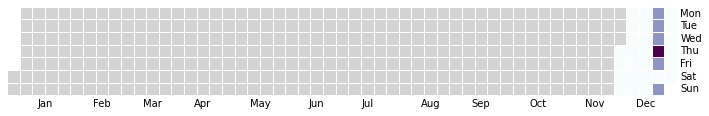

In [40]:
from matplotlib.pyplot import figure

figure(figsize=(12, 12))
cmap = calmap.yearplot(year["Bool"], cmap='BuPu', fillcolor='lightgray')
cmap

In [41]:
week = time_df["Date"].dt.isocalendar()
time_df["Week"] = week["week"]

In [54]:
weekdays = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Sunday"]

time_df = pd.DataFrame()
time_df["Date"] = pd.date_range('2022-12-01', periods=365)
time_df["Day"] = time_df["Date"].dt.day_name()

year = pd.merge(time_df, heatmap_data, how="outer", on="Date")
year["Item"] = year["Item"].replace(np.nan, 0) 
year["Bool"] = np.where(year["Item"] == 0, 0, 1)

week = time_df["Date"].dt.isocalendar()
year["Week"] = week["week"].fillna(52)
year["Week"] = year["Week"].fillna(52)

year.tail(5)

,Date,Day,ID,Item,Color,Pattern,Category,Bool,Week
361,2023-11-26,Sunday,NaN,0,NaN,NaN,NaN,0,48
362,2023-11-27,Monday,NaN,0,NaN,NaN,NaN,0,48
363,2023-11-28,Tuesday,NaN,0,NaN,NaN,NaN,0,48
364,2023-11-29,Wednesday,NaN,0,NaN,NaN,NaN,0,48
365,2023-11-30,Thursday,NaN,0,NaN,NaN,NaN,0,52


In [43]:
alt.Chart(year, title="Heatmap of Green Totebag Wears").mark_rect(
    stroke="white",
    strokeWidth=3,
    opacity=0.9
    ).encode(
    alt.X("Week:O", 
          axis = alt.Axis(labelAngle=-45)
         ), 
    alt.Y("Day", 
          sort=weekdays),
    alt.Color("Bool", 
              scale=alt.Scale(scheme='greenblue'),
              legend=None
             ),
    alt.Tooltip(["Date", "Day"])
    ).properties(
    height=200,
    width=700
    )

alt.Chart(...)

In [44]:
# scale=alt.Scale(
#             domain=[-10,-5,0,5,9], 
#             range=['red','orange','white','lightblue','darkblue'], 
#             interpolate=method
#             )

In [45]:
alt.Chart(year, title="Heatmap of Green Totebag Wears").mark_rect(
    stroke="white",
    strokeWidth=3,
    opacity=0.9,
    ).encode(
    alt.X("Week:O", 
          axis = alt.Axis(labelAngle=-45)
         ), 
    alt.Y("Day", 
          sort=weekdays),
    alt.Color("Bool", 
            scale=alt.Scale(
                domain=[0,1], 
                range=["#e0ddd5", "#7c9e7b"]),
                legend=None
             ),
    alt.Tooltip(["Date", "Day"])
    ).properties(
    height=200,
    width=600
    )

alt.Chart(...)

In [46]:
year.iloc[16:18]

,Date,Day,ID,Item,Color,Pattern,Category,Bool,Week
16,2022-12-17,Saturday,NaN,0,NaN,NaN,NaN,0,50
17,2022-12-18,Sunday,NaN,0,NaN,NaN,NaN,0,50


idea: fix week x axis to dates
- also what happened dec 18th lol

oh I think if the x axis is by week then everything will look better

In [56]:
year['First_day'] = year['Date'] - year['Date'].dt.weekday * np.timedelta64(1, 'D')

# year["Week2"] = year["Week"].fillna(52)

year

,Date,Day,ID,Item,Color,Pattern,Category,Bool,Week,First_day,Week2
0,2022-12-01,Thursday,NaN,0,NaN,NaN,NaN,0,48,2022-11-28,48
1,2022-12-02,Friday,NaN,0,NaN,NaN,NaN,0,48,2022-11-28,48
2,2022-12-03,Saturday,NaN,0,NaN,NaN,NaN,0,48,2022-11-28,48
3,2022-12-04,Sunday,NaN,0,NaN,NaN,NaN,0,48,2022-11-28,48
4,2022-12-05,Monday,NaN,0,NaN,NaN,NaN,0,49,2022-12-05,49
...,...,...,...,...,...,...,...,...,...,...,...
361,2023-11-26,Sunday,NaN,0,NaN,NaN,NaN,0,48,2023-11-20,48
362,2023-11-27,Monday,NaN,0,NaN,NaN,NaN,0,48,2023-11-27,48
363,2023-11-28,Tuesday,NaN,0,NaN,NaN,NaN,0,48,2023-11-27,48
364,2023-11-29,Wednesday,NaN,0,NaN,NaN,NaN,0,48,2023-11-27,48


In [71]:
alt.Chart(year, title="Heatmap of Green Totebag Wears").mark_rect(
    stroke="white",
    strokeWidth=3,
    opacity=0.9,
    ).encode(
    alt.X("First_day:O", 
          axis = alt.Axis(labelAngle=-45,
#                           format="%B"
                         )
         ), 
    alt.Y("Day", 
          sort=weekdays),
    alt.Color("Bool", 
            scale=alt.Scale(
                domain=[0,1], 
                range=["#e0ddd5", "#7c9e7b"]),
                legend=None
             ),
    alt.Tooltip(["Date", "Day"])
    ).properties(
    height=200,
    width=600
    )

alt.Chart(...)

In [81]:
week = time_df["Date"].dt.strftime('%m-%d-%y')

0      12-01-22
1      12-02-22
2      12-03-22
3      12-04-22
4      12-05-22
         ...   
360    11-26-23
361    11-27-23
362    11-28-23
363    11-29-23
364    11-30-23
Name: Date, Length: 365, dtype: object

In [ ]:
week = time_df["Date"].dt.strftime('%m-%d-%y')
year['D'] = year['Date'] - year['Date'].dt.weekday * np.timedelta64(1, 'D')

# year["Week2"] = year["Week"].fillna(52)

year

This is cool but 
1) Interactivity?
2) Does this work with dash hmhmhmmhmhmhmmm

TO DO NEXT:
- fix the concat'd function to plot y ="count"
- color scheme of plots 


IDEA: 
- heatmap of year and most worn item (this is where image could pop up)
    - omg so fun im excited
- is there anyway to read google sheet data in automatically? its a pain to download everytime for testing

# Note to self 
-- maybe add ID into google sheet for easier merging later?